In [0]:
import cv2
import numpy as np
from google.colab import drive
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
img=cv2.imread('/content/gdrive/My Drive/plate.jpg')

In [0]:
#img = cv2.resize(img,(img.shape[0]*4,img.shape[1]*3))

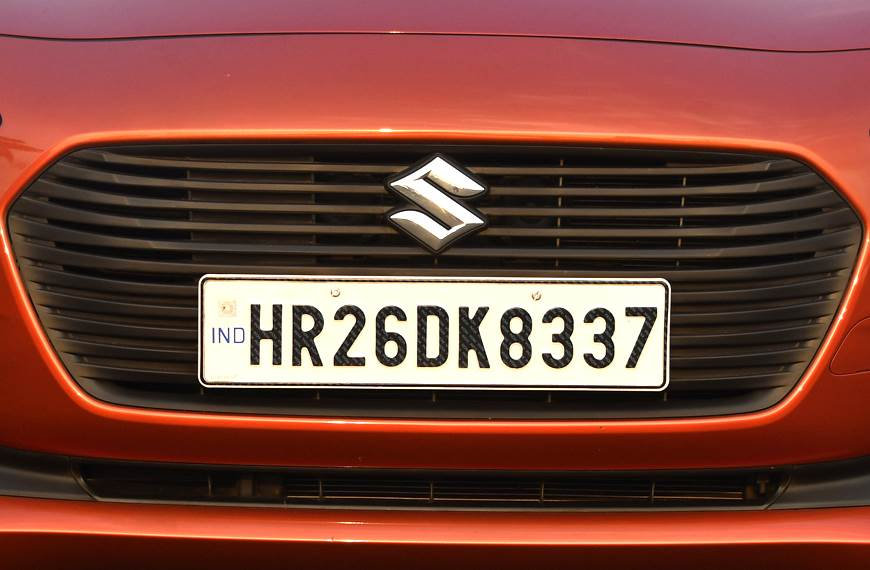

In [5]:
cv2_imshow(img)

In [0]:
hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

In [0]:
hsv = cv2.bilateralFilter(hsv,9,5,5)

In [8]:
c=input('Enter the color : ')

Enter the color : W


In [0]:
lower_yellow=np.array([20,100,100]) 
upper_yellow=np.array([50,255,255])
lower_white = np.array([0,0,160], dtype=np.uint8)
upper_white = np.array([255,40,255], dtype=np.uint8)
#lower_yellow=np.array([20,100,100]) 
#upper_yellow=np.array([28,255,255]) 
mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
mask2= cv2.inRange(hsv, lower_white, upper_white)
if c=="Y":
  mask3=mask
if c=="W":
  mask3=mask2

In [0]:
res = cv2.bitwise_and(img,img, mask= mask3)

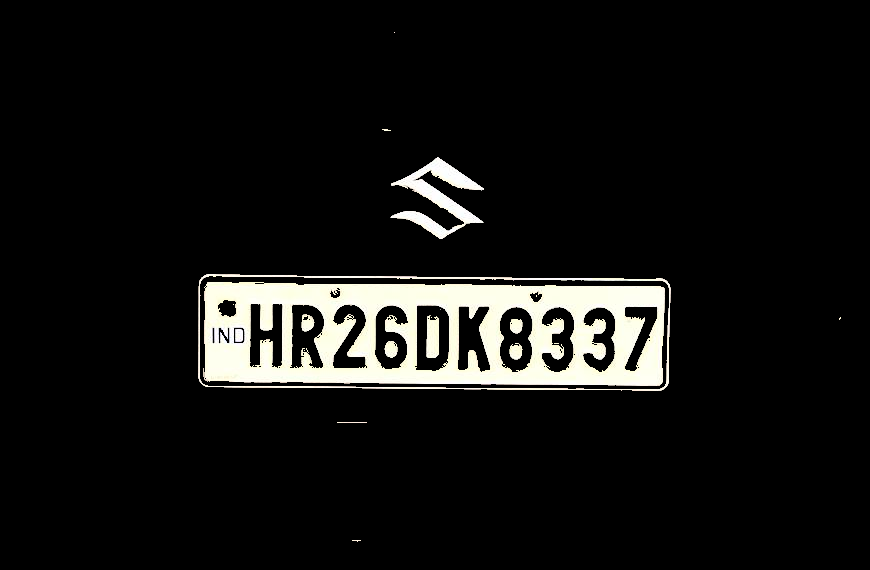

In [11]:
cv2_imshow(res)

In [0]:
img_gray=cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

In [0]:
#equal_histogram = cv2.equalizeHist(img_gray)

In [0]:
#cv2_imshow(equal_histogram)

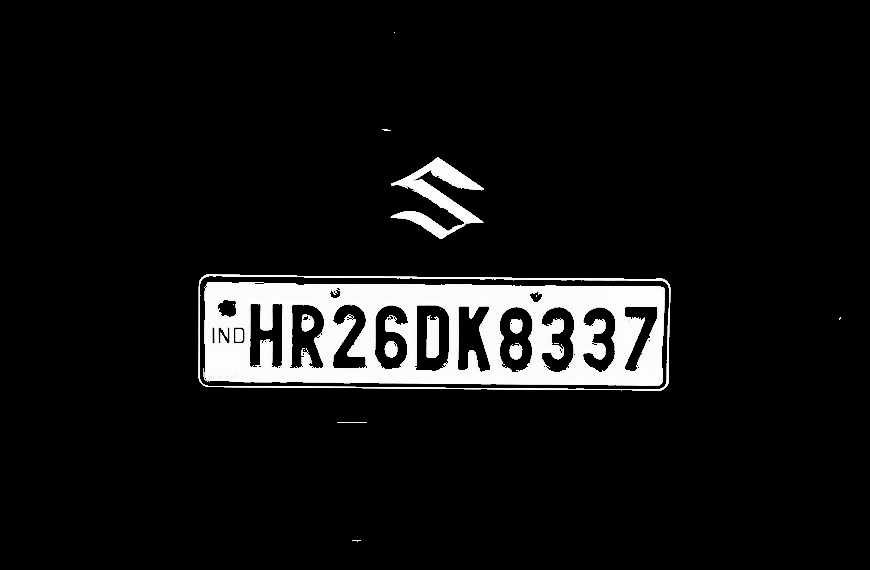

In [15]:
cv2_imshow(img_gray)

In [0]:
kernel = np.ones((7,7), np.uint8) 
kernel2 = np.ones((5,5), np.uint8) 

In [0]:
closing = cv2.morphologyEx(img_gray, cv2.MORPH_CLOSE, kernel)

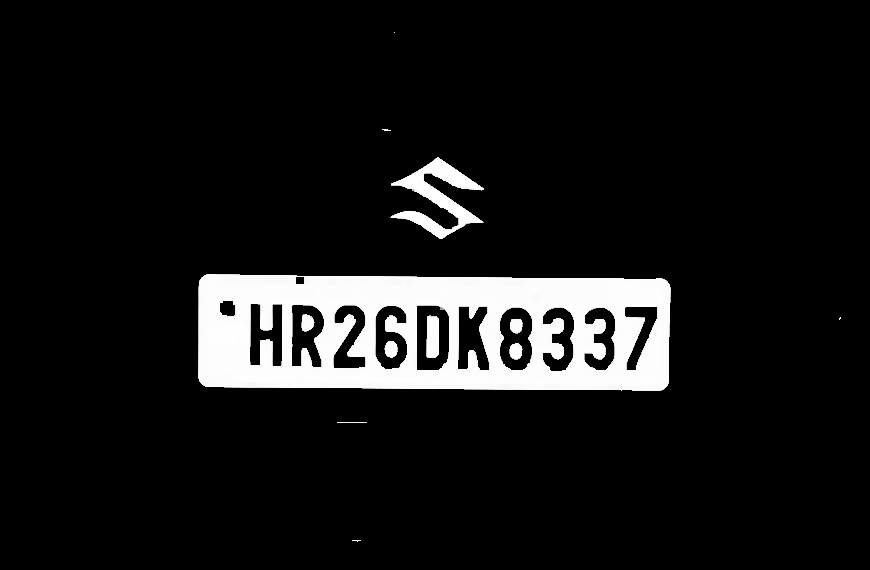

In [18]:
cv2_imshow(closing)

In [0]:
#dilate1=cv2.dilate(img_gray, kernel2, iterations=1)
dilate1=closing

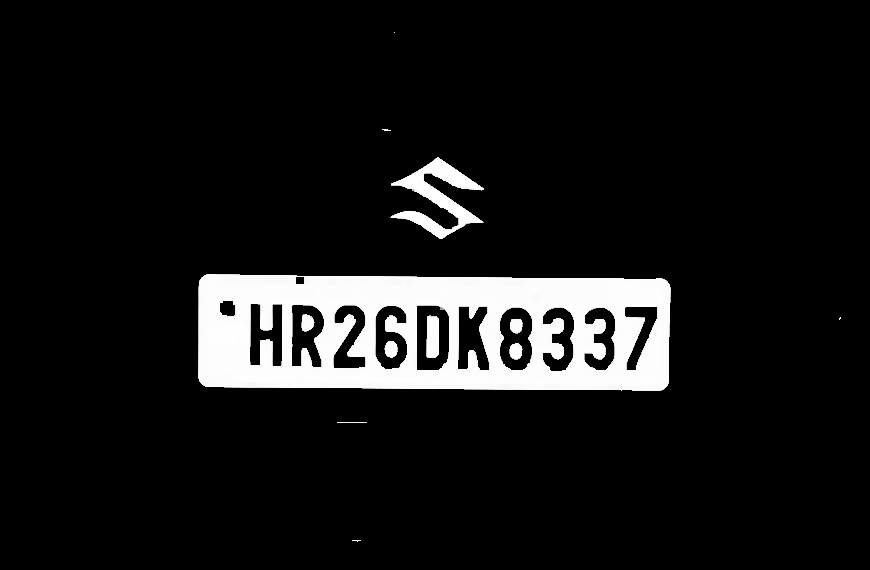

In [20]:
cv2_imshow(dilate1)

In [0]:
#erode = cv2.erode(dilate1, kernel, iterations=2) 
#img_dilation = cv2.dilate(img_gray, kernel, iterations=2) 

In [0]:
#cv2_imshow(erode)

In [0]:
#erode=cv2.erode(img_dilation, kernel, iterations=)

In [0]:
#dilate=cv2.dilate(erode, kernel, iterations=1) 

In [0]:
#cv2_imshow(dilate)

In [0]:
ret,thresh_image = cv2.threshold(dilate1,0,255,cv2.THRESH_OTSU)

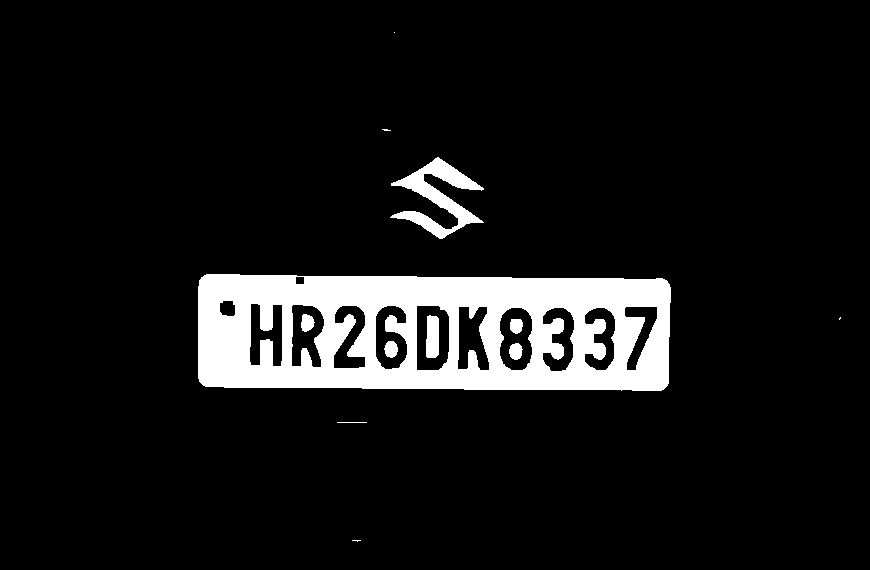

In [27]:
cv2_imshow(thresh_image)

In [0]:
canny_image = cv2.Canny(thresh_image,25,25)

In [0]:
#canny_image = cv2.convertScaleAbs(canny_image)

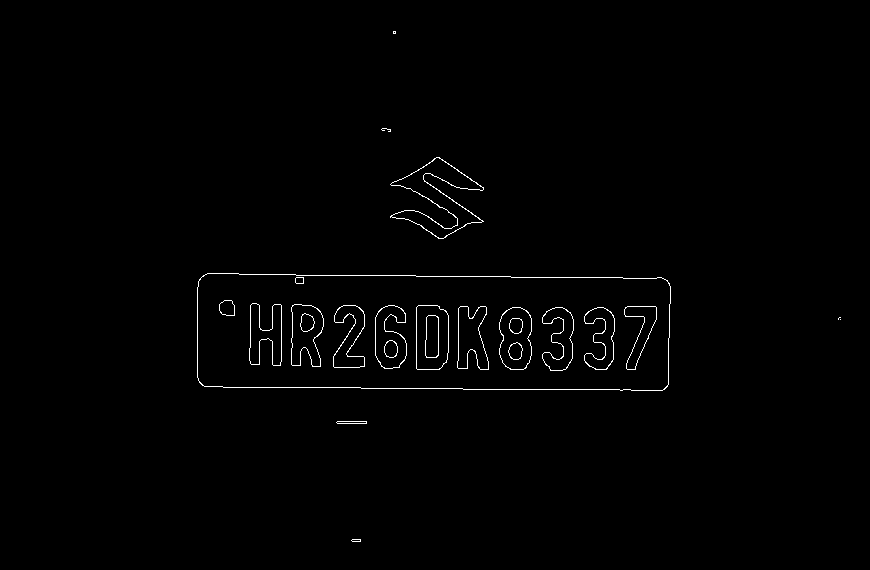

In [30]:
cv2_imshow(canny_image)

In [0]:
kernel3 = np.ones((2,2), np.uint8)

In [0]:
dilated_canny = cv2.dilate(canny_image,kernel3,iterations=2)

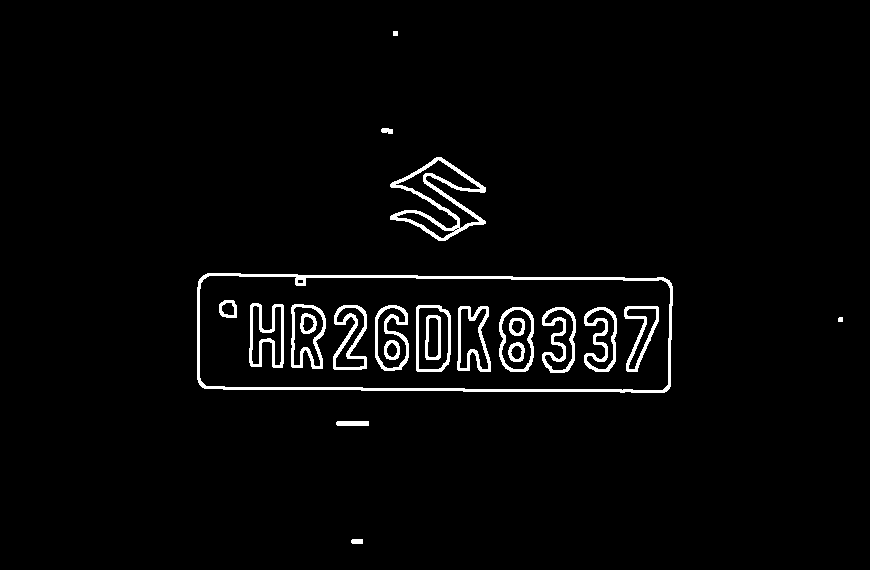

In [33]:
cv2_imshow(dilated_canny)

In [0]:
new,contours, hierarchy = cv2.findContours(dilated_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [0]:
contours= sorted(contours, key = cv2.contourArea, reverse = True)[:5]

In [0]:
#cv2_imshow(cv2.drawContours(img, contours, -1, (0,0,255), 2))

In [0]:
screenCnt=[]

In [0]:
for c in contours:
  #hull = cv2.convexHull(c)
  #hullArea = cv2.contourArea(hull)
  #solidity=area/
	#solidity = area/float(hullArea)
  peri = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.05 * peri, True)
  approx1=cv2.approxPolyDP(c, 0.1 * peri, True)
  if((len(approx) >=4 and len(approx)<=5 or (cv2.contourArea(approx)>=2000 and cv2.contourArea(approx)<=4000)) or (len(approx1) >=4 and len(approx1)<=5 or (cv2.contourArea(approx1)>=2000 and cv2.contourArea(approx1)<=4000))):
    screenCnt.append(approx)
    #break
for i in screenCnt:
  final = cv2.drawContours(img_gray, [i], -1, (0, 255, 0), 0)

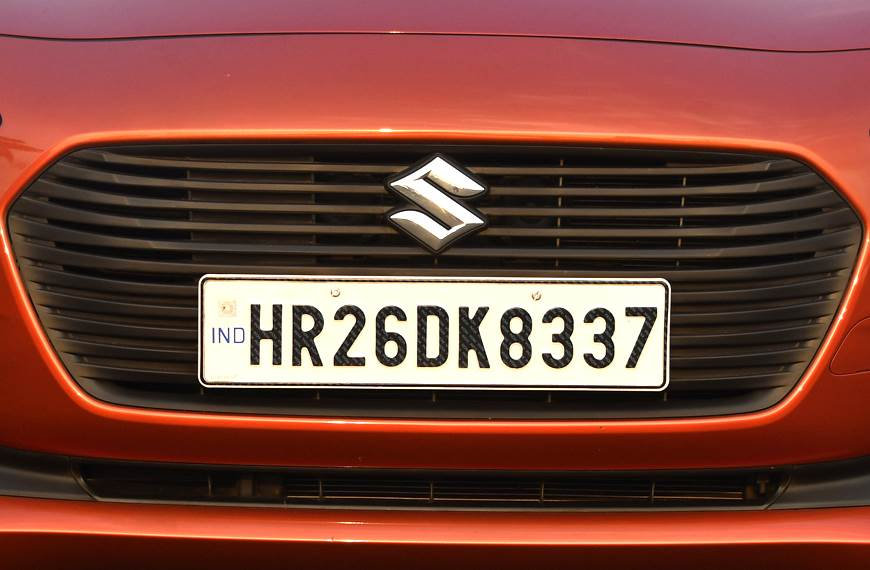

In [39]:
cv2_imshow(img)

In [0]:
def for_point_warp(cnt, orig):
    pts = cnt.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warp = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))
    return warp

In [0]:
def resize(img, width=None, height=None, interpolation = cv2.INTER_AREA):
    global ratio
    w, h, _ = img.shape

    if width is None and height is None:
        return img
    elif width is None:
        ratio = height/h
        width = int(w*ratio)
        print(width)
        resized = cv2.resize(img, (height, width), interpolation)
        return resized
    else:
        ratio = width/w
        height = int(h*ratio)
        print(height)
        resized = cv2.resize(img, (height, width), interpolation)
        return resized

EO


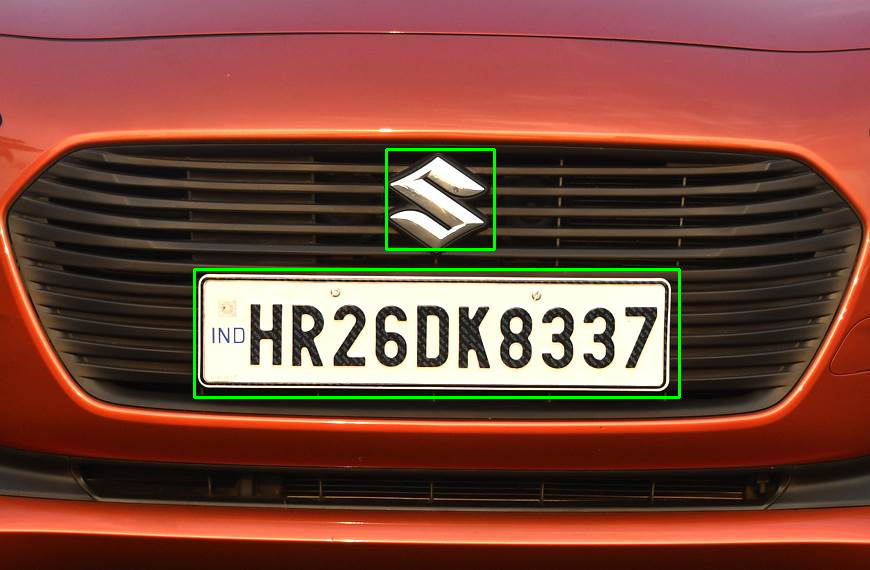

In [42]:
#screenCnt.shape
c=0
img_read=[]
for i in screenCnt:
  if(len(i)>3):
    if(c==2):
      break
    x, y, w, h = cv2.boundingRect(i)
    if(w>h):
      dst=cv2.rectangle(img, (x-4, y-8), (x+w+8, y+h+8), (0, 255, 0), 2)
      try:
        img_read.append(for_point_warp(i, img))
      except:
        print("EO")
    c=c+1
cv2_imshow(dst)

In [0]:
if(len(img_read)==2):
  img1=img_read[0]
  img2=img_read[1]
  h1, w1 = img1.shape[:2]
  h2, w2 = img2.shape[:2]
  vis = np.zeros((max(h1, h2), w1+w2,3), np.uint8)
  vis[:h1, :w1,:3] = img1
  vis[:h2, w1:w1+w2,:3] = img2
else:
  vis=img_read[0]

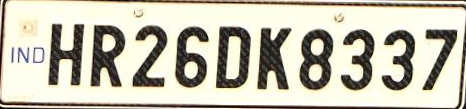

In [44]:
cv2_imshow(vis)

In [45]:
vis = resize(vis , height=500)

116


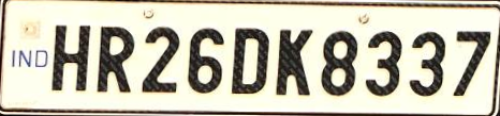

In [46]:
cv2_imshow(vis)

In [0]:
vis_gray=cv2.cvtColor(vis, cv2.COLOR_BGR2GRAY)

In [0]:
#ret,thresh_image = cv2.threshold(vis_gray,0,255,cv2.THRESH_OTSU)

In [0]:
#edges = cv2.Canny(vis_gray,100,200)

In [0]:
#cv2_imshow(edges)

In [0]:
#!pip install tesseract

In [0]:
#!sudo apt install tesseract-ocr

In [0]:
#!pip install pytesseract

In [0]:
import pytesseract

In [0]:
num = pytesseract.image_to_string(vis)

In [56]:
print(num)

HR26DK8337


In [0]:
#len(screenCnt)

In [0]:
#screenCnt[1].shape

In [0]:
#from PIL import Image

In [0]:
#!pip install scipy

In [0]:
#viss=255-vis
#cv2_imshow(viss)

In [0]:
#Character recognition using Template Matchiing


In [0]:
from skimage.transform import resize
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches


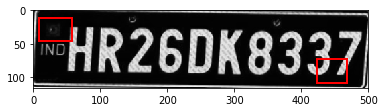

In [63]:


# The invert was done so as to convert the black pixel to white pixel and vice versa
license_plate = np.invert(vis_gray)
labelled_plate = measure.label(license_plate)
fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")
# the next two lines is based on the assumptions that the width of
# a license plate should be between 5% and 15% of the license plate,
# and height should be between 35% and 60%
# this will eliminate some
character_dimensions = (0.3*license_plate.shape[0], 0.60*license_plate.shape[0], 0.05*license_plate.shape[1], 0.15*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter=0
column_list = []
for regions in regionprops(labelled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)

        # this is just to keep track of the arrangement of the characters
        column_list.append(x0)
# print(characters)
plt.show()

In [64]:
column_list

[9, 423]

In [0]:
template=cv2.imread('/content/gdrive/My Drive/D.jpg' ,0)

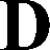

In [66]:
cv2_imshow(template)

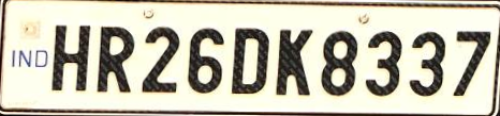

In [67]:
w, h = template.shape[::-1] 

res = cv2.matchTemplate(vis_gray,template,cv2.TM_CCOEFF_NORMED) 
 
threshold = 0.7
  
# Store the coordinates of matched area in a numpy array 
loc = np.where( res >= threshold)  
  
# Draw a rectangle around the matched region. 
for pt in zip(*loc[::-1]): 
    cv2.rectangle(vis, pt, (pt[0] + w, pt[1] + h), (0,255,255), 2) 
  
# Show the final image with the matched area. 
cv2_imshow(vis) 